In [1]:
import glob
import numpy as np
import gpflow
import pandas as pd

In [2]:
from MATSgp.lineshape_meanfuncs import *
from MATSgp.gp_models import SwitchedGPR

import matplotlib.pyplot as plt

HAPI version: 1.1.1.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


2021-08-26 11:35:19.531209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read in some data

In [3]:
dat_files = glob.glob('../Examples/Multiple Temperature Oxygen A-Band/*etalon.csv')
dat_files.sort()
dat_files

['../Examples/Multiple Temperature Oxygen A-Band/13Feb18_255K_0.2%_1000Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/14Feb18_255K_0.2%_700Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/16Feb18_255K_0.2%_200Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/17Feb18_255K_0.2%_100Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/18Feb18_255K_0.2%_50Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/1Feb18_273K_0.2%_700Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/21Feb18_237.5K_0.2%_1000Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/22Feb18_237.5K_0.2%_700Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/23Feb18_237.5K_0.2%_400Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/26Feb18_237.5K_0.2%_200Torr_etalon_Seg2_etalo

In [4]:
dat = [np.loadtxt(f, delimiter=',', skiprows=1, usecols=[6, 8, 10, 14]) for f in dat_files]

In [5]:
#Create information on each dataset
data_info_list = []

for i, f in enumerate(dat_files):
    start_ind = f.find('_2')
    end_ind = f.find('K_')
    nom_temp = np.floor(float(f[start_ind+1:end_ind]))
    data_info_list.append(SpectralDataInfo(fittable=True,
                                           mole_frac=0.002022,
                                           x_shift=0.0,
                                           nominal_temp=nom_temp,
                                           abun_ratio=1.0/0.995262,
                                           constraint_dict={'x_shift': (-0.1, 0.1)})
                         )
    gpflow.set_trainable(data_info_list[-1].params['x_shift'], True)


2021-08-26 11:35:21.896778: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [6]:
x = [d[:, [2, 0, 1]] for d in dat]
for d in x:
    #d[:, 0] *= (10**6) #/ 29979245800 #Load wavenumbers directly
    d[:, 1] = np.average(d[:, 1]) + 273.15
    d[:, 2] = np.average(d[:, 2]) / 760.0
    
x = [np.hstack([x[i], np.ones((x[i].shape[0], 1))*i]) for i in range(len(x))]

y = [d[:, 3] for d in dat]

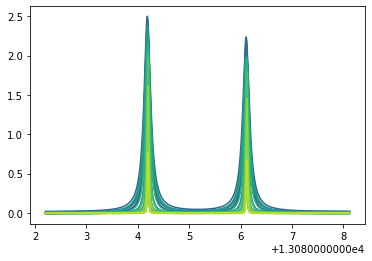

In [7]:
fig, ax = plt.subplots()
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(x)))
for i in range(len(x)):
    ax.plot(x[i][:, 0], y[i], color=colors[i])
plt.show()

# Perform some fitting

In [8]:
#Define a noise scale to make training a little more robust
noise_scale = np.average([np.std(y[i][:10]) for i in range(len(y))])
print(noise_scale)

0.0003014654543466952


In [9]:
lineparam_list = pd.read_csv('../Examples/Multiple Temperature Oxygen A-Band/Parameter_LineList.csv', index_col=0)
line_list = []
for i, line in lineparam_list.iterrows():
    line_list.append(lineshape_from_dataframe(line,
                                              limit_factor_dict={'SD_gamma_air':(0.01, 0.25)},
                                              line_kwargs={'dset_list':data_info_list,
                                                           'linemix':linemix_from_dataframe(line,
                                                                linemix_kwargs={'fittable':(line['sw'] >= 1.0)}),
                                                           'cutoff':50,
                                                           'noise_scale_factor':noise_scale,
                                                           'fittable':(line['sw'] >= 1.0)},
                                             )
                    )

In [10]:
for line in line_list:
    
    if isinstance(line.params['nu'], gpflow.Parameter):
        gpflow.set_trainable(line.params['nu'], True)
        gpflow.set_trainable(line.params['sw'], True)
        gpflow.set_trainable(line.params['n_gamma0'], True)
        gpflow.set_trainable(line.params['n_delta0'], True)
    
    line.params['n_gamma2'] = line.params['n_gamma0']

In [11]:
#And baselines, too!
baselines = Baseline(np.zeros(len(data_info_list)),
                     np.zeros(len(data_info_list)),
                     np.zeros(len(data_info_list)),
                     [np.min(xdat[:, 0]) for xdat in x],
                     dset_list=data_info_list,
                     noise_scale_factor=noise_scale,
                     fittable=True)

for param in ['c0', 'c1']: #Only allow fitting to first linear order
    gpflow.set_trainable(baselines.params[param], True)


In [12]:
mean_func = ComboMeanFunc(line_list+[baselines,])

In [13]:
#Define class object which, when called, provides mean squared residual
class least_squares_obj(object):
    def __init__(self, x_data, y_data, fit_func):
        self.x = x_data
        self.y = y_data
        self.f = fit_func
    
    def __call__(self):
        f_vals = self.f(self.x)
        res_sq = tf.square(f_vals - self.y)
        return tf.reduce_mean(res_sq)


In [14]:
#Set up data and objective
objective = least_squares_obj(np.vstack(x), np.hstack(y)[:, None]/noise_scale, mean_func)

objective()

<tf.Tensor: shape=(), dtype=float64, numpy=288764.471895982>

In [15]:
%%time
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(objective, mean_func.trainable_variables, options=dict(maxiter=500))

2021-08-26 11:44:02.368786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 25min 36s, sys: 8min 2s, total: 33min 38s
Wall time: 15min 21s


In [16]:
#Check out the documentation for gpflow.optimizers.Scipy
#It's essentially just a wrapper around scipy optimizers (can specify which one with method='L-BFGS-B', etc.)
#But it calculates all the gradients with tensorflow
opt_logs

      fun: 547.8382759293295
 hess_inv: <121x121 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.04050691e+01,  4.17091154e+01,  1.26832569e+02,  1.13927277e+02,
       -9.91700662e-01,  7.83566076e+01, -8.42291986e+01, -1.25936756e+00,
        1.37644831e+01,  1.67938452e+02,  7.01067994e+01,  7.46574493e+01,
        3.49330309e+01, -2.26872473e+02,  3.44591912e+01, -2.50582642e+02,
        6.18906215e+01, -1.20097819e+02,  1.65429708e+02, -2.14487742e+02,
       -1.17114797e+02,  2.21889389e+02, -9.16100992e+01, -1.45891202e+04,
        1.51802881e+01, -2.14257562e+02,  2.46225916e+02,  1.75750202e+02,
        4.08764961e+01,  1.36647662e+01,  5.67798728e+00,  2.47691857e+02,
       -2.11751979e+02, -2.13773530e+02, -8.88006875e+01, -5.02822884e+01,
       -2.18669201e+01, -3.48602593e+00,  9.47348258e+01,  5.43001092e+02,
       -9.39510088e-01,  3.92499298e+02, -1.06300936e+01,  1.29581921e+02,
       -2.62077743e+01, -6.42591405e+00, -1.73893954e+01, -8.99367632e+00,


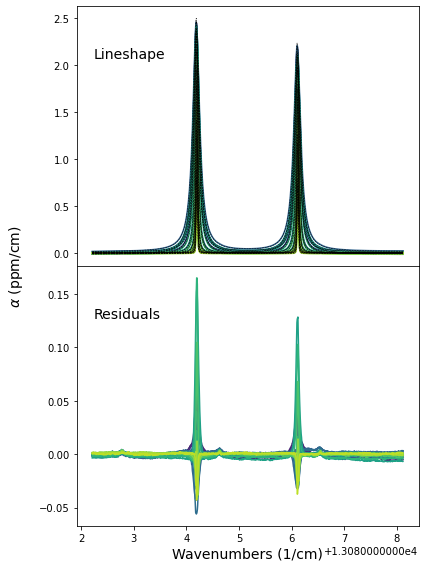

In [17]:
#%matplotlib notebook

colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(x)))

fig, ax = plt.subplots(2, sharex=True, sharey=False, figsize=(6, 8))

for i in range(len(x)):
    line = noise_scale * mean_func(x[i]).numpy().flatten()
    ax[0].plot(x[i][:, 0], line, color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line - y[i], color=colors[i])

ax[0].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[0].yaxis.set_label_coords(-0.15, 0.0)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Residuals', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

In [18]:
mean_func

name,class,transform,prior,trainable,shape,dtype,value
ComboMeanFunc.mean_funcs[0].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[1].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[2].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[3].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[4].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[5].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[6].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[7].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[8].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[9].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[10].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[11].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[12].dset_list[0].params['mole_frac'] ComboMeanFunc.mean_funcs[13].dset_list[0].params['mole_frac'],Parameter,Identity,,False,(),float64,0.002022
ComboMeanFunc.mean_funcs[0].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[1].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[2].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[3].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[4].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[5].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[6].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[7].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[8].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[9].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[10].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[11].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[12].dset_list[0].params['x_shift'] ComboMeanFunc.mean_funcs[13].dset_list[0].params['x_shift'],Parameter,SoftClip,,True,(),float64,-0.0003091293533972195
ComboMeanFunc.mean_funcs[0].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[1].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[2].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[3].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[4].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[5].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[6].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[7].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[8].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[9].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[10].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[11].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[12].dset_list[1].params['mole_frac'] ComboMeanFunc.mean_funcs[13].dset_list[1].params['mole_frac'],Parameter,Identity,,False,(),float64,0.002022
ComboMeanFunc.mean_funcs[0].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[1].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[2].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[3].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[4].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[5].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[6].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[7].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[8].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[9].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[10].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[11].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[12].dset_list[1].params['x_shift'] ComboMeanFunc.mean_funcs[13].dset_list[1].params['x_shift'],Parameter,SoftClip,,True,(),float64,0.00029125006540932363
ComboMeanFunc.mean_funcs[0].dset_list[2].params['mole_frac'] ComboMeanFunc.mean_funcs[1].dset_list[2].params['mole_frac'] ComboMeanFunc.mean_funcs[2].dset_list[2].params['mole_frac'] ComboMeanFunc.mean_funcs[3].dset_list[2].params['mole_frac'] ComboMeanFunc.mean_funcs[4].dset_list[2].params['mole_frac'] ComboMeanFunc.mean_funcs[5].dset_list[2].params['mole_

In [213]:
#If tensorflow/gpflow implementation of model is way slower (in particular for training), can just model residuals
#Don't feel as good about this because lose consistency in loss and probabilistic interpretation
residual_data = np.load('../Examples/Multiple Temperature Oxygen A-Band/residual_data.npy')
res_x = []
res_y = []
len_count = 0
for i in range(len(x)):
    res_x.append(residual_data[len_count:len_count+x[i].shape[0], :-1])
    res_y.append(residual_data[len_count:len_count+y[i].shape[0], -1])
    len_count += x[i].shape[0]
    
# residual = noise_scale * mean_func(np.vstack(x)).numpy() - np.hstack(y)[:, None]
# residual_data = np.hstack([np.vstack(x), residual])

noise_scale = np.average([np.std(res_y[i]) for i in range(len(res_y))])
print(noise_scale)
noise_scale = 1.0

0.0022842613933126152


In [215]:
#Create gpflow model
gpflow.config.set_default_jitter(1e-06)

test_x = residual_data[:, :-1] #np.vstack(x)
#Add column in y to indicate different likelihoods, i.e., different noise on different experimental datasets
test_y = residual_data[:, -1:] #np.vstack([np.vstack([y[i], np.ones_like(y[i])*i]).T for i in range(len(y))])
print(test_x.shape)
print(test_y.shape)

#Noise variance is around 1e-6 or 1e-07, which is an issue for GPflow
#To avoid numerical problems, scale output by noise standard deviation so noise variance will be order 1
# test_y[:, 0] /= noise_scale
test_y /= noise_scale

#Specify kernel that ignores the dimension specifying just the dataset index
kern = gpflow.kernels.SquaredExponential(lengthscales=np.ones(3),#1.0*(np.amax(test_x[:, :-1], axis=0)
                                                      #     - np.amin(test_x[:, :-1], axis=0)),
                                         active_dims=[0, 1, 2])
# kern = gpflow.kernels.Linear(variance=[1.0, 1.0, 1.0], active_dims=[0, 1, 2])

#Define our Gaussian process regression model
# gpr = SwitchedGPR(data=(test_x, test_y),
#                   kernel=kern,
#                   mean_function=mean_func,
#                   noise_variance=[1.0]*len(y))

#But woah, 21860 data points? That's too many to handle for standard GPR
#Switch to sparse GPR, though don't have switched likelihood version yet...
induce_pts = gpflow.inducing_variables.InducingPoints(np.vstack([xdat[1::int(xdat.shape[0]/15)]
                                                                 for xdat in x]))
# induce_pts = gpflow.inducing_variables.InducingPoints(np.vstack([xdat[np.random.choice(xdat.shape[0], size=10)]
#                                                                  for xdat in x]))
gpr = gpflow.models.SGPR(data=(test_x, test_y),# test_y[:, :1]),
                         kernel=kern,
                         inducing_variable=induce_pts,
#                          mean_function=mean_func,
                         noise_variance=1e-4,
                         num_latent_gps=1)

(21860, 4)
(21860, 1)


In [216]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[1. 1. 1.]
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00010000000000000011
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(367, 4)",float64,"[[1.30822122e+04, 2.54993940e+02, 1.23739205e+00..."


<IPython.core.display.Javascript object>


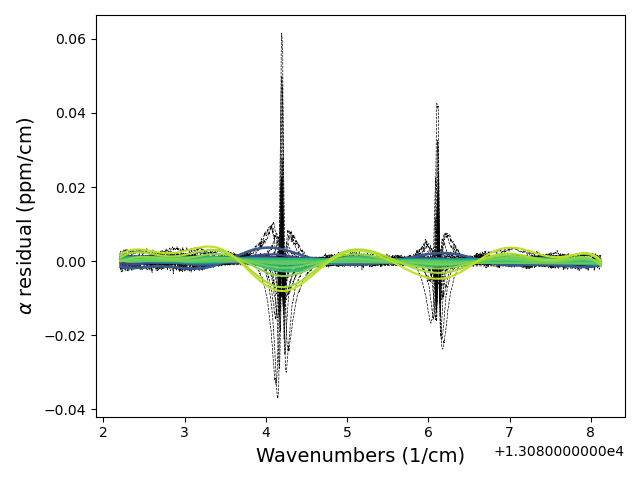

In [217]:
%matplotlib notebook

#Predictions before training
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(x)))

fig, ax = plt.subplots()

for i in range(len(x)):
    mean, var = gpr.predict_f(res_x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    ax.plot(res_x[i][:, 0], mean, color=colors[i])
    ax.plot(res_x[i][:, 0], res_y[i], 'k--', linewidth=0.5, zorder=0)

ax.set_ylabel(r'$\alpha$ residual (ppm/cm)', fontsize=14)
ax.set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)

fig.tight_layout()
plt.show()

In [218]:
%%time

gpflow.set_trainable(gpr.inducing_variable.Z, False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=500))

CPU times: user 2min 50s, sys: 28.1 s, total: 3min 19s
Wall time: 46.3 s


In [219]:
opt_logs

      fun: -97922.65500903383
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01659898, -0.0036809 ,  0.01555415, -0.01650756, -0.00813606])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 58
      nit: 38
     njev: 58
   status: 0
  success: True
        x: array([ -0.87919954,   2.73984873,   0.57637357, -13.21227905,
       -11.96613859])

In [186]:
%%time

gpflow.set_trainable(gpr.inducing_variable.Z, True)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=500))

InvalidArgumentError:  Input matrix is not invertible.
	 [[node gradient_tape/triangular_solve_1/MatrixTriangularSolve (defined at /Users/jim2/bin/miniforge3/envs/MATSgp-env/lib/python3.8/site-packages/gpflow/optimizers/scipy.py:173) ]] [Op:__inference__tf_eval_1232642]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/triangular_solve_1/MatrixTriangularSolve:
 Cholesky (defined at /Users/jim2/bin/miniforge3/envs/MATSgp-env/lib/python3.8/site-packages/gpflow/models/sgpr.py:172)

Function call stack:
_tf_eval


In [105]:
opt_logs

      fun: -97771.09556818736
 hess_inv: <469x469 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.95028689e-01, -1.49763816e-03,  2.73020225e-02,  0.00000000e+00,
        4.81649303e-02,  3.24867582e-02,  2.61840080e-01,  0.00000000e+00,
       -3.42566538e-01,  2.28713284e-03, -2.06142279e-01,  0.00000000e+00,
       -2.72779985e-02,  1.76650967e-02, -6.50766929e-02,  0.00000000e+00,
       -4.42513956e-02, -7.04443621e-03,  1.11270526e-01,  0.00000000e+00,
       -6.41600792e-02,  7.86171330e-03, -8.66095925e-02,  0.00000000e+00,
       -2.34924770e-01, -1.74826598e-02,  2.27356406e-02,  0.00000000e+00,
       -1.91751439e-01,  1.00231000e-02, -7.18714546e-02,  0.00000000e+00,
       -3.22416908e-01,  2.70899391e-03, -1.97721824e-01,  0.00000000e+00,
        1.08425519e-01,  9.94897701e-03,  2.02188329e-01,  0.00000000e+00,
        1.69224990e-01,  3.98888757e-03,  1.81679470e-02,  0.00000000e+00,
       -2.03919609e-01, -1.93758424e-03, -1.34340120e-01,  0.00000000e+00,

In [220]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.8280148369391998e-06
SGPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.34721084 2.8024292 1.02229739]
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,7.355806429109738e-06
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(367, 4)",float64,"[[1.30822122e+04, 2.54993940e+02, 1.23739205e+00..."


<IPython.core.display.Javascript object>


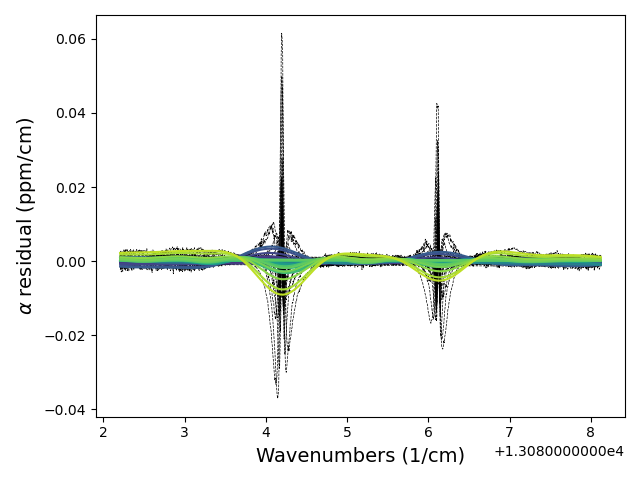

In [221]:
#Predictions after training
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(x)))

fig, ax = plt.subplots()

for i in range(len(x)):
    mean, var = gpr.predict_f(res_x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    ax.plot(res_x[i][:, 0], mean, color=colors[i])
    ax.plot(res_x[i][:, 0], res_y[i], 'k--', linewidth=0.5, zorder=0)

ax.set_ylabel(r'$\alpha$ residual (ppm/cm)', fontsize=14)
ax.set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


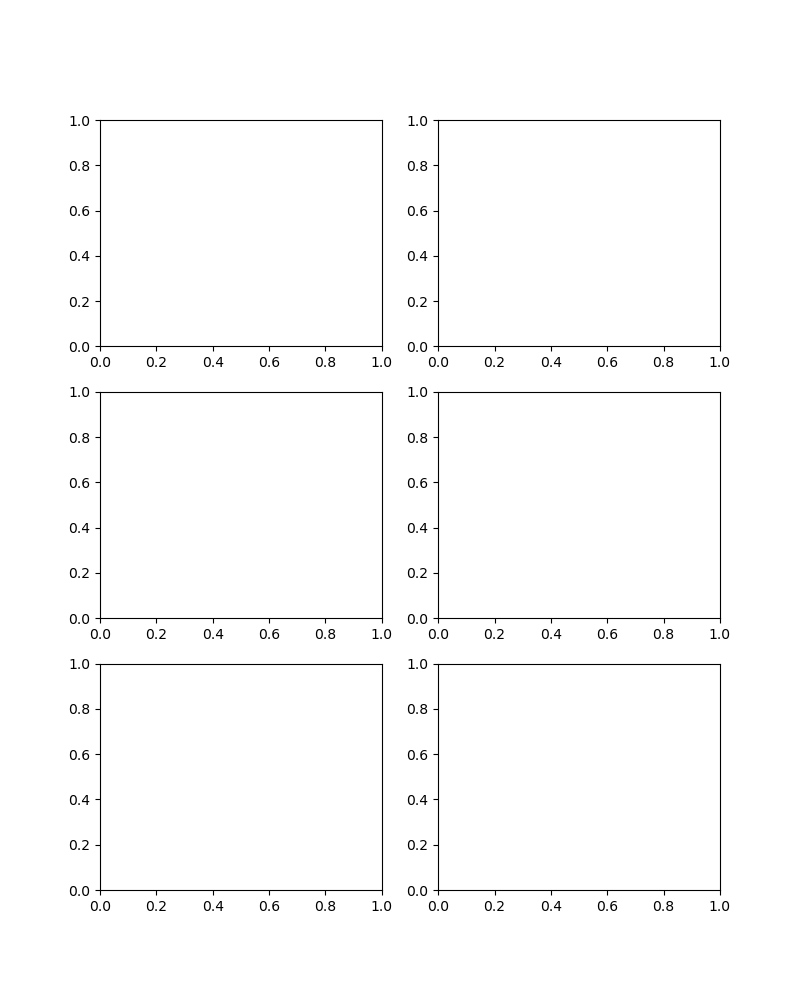

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [32]:
#Look at uncertainty as a function of wavenumber, temperature, pressure
x_vals = np.linspace(np.min(test_x[:, 0]), np.max(test_x[:, 0]), 500)
t_vals = np.linspace(np.min(test_x[:, 1]), np.max(test_x[:, 1]), 50)
p_vals = np.linspace(np.min(test_x[:, 2]), np.max(test_x[:, 2]), 50)

xt_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, t_vals)]).T
xt_grid = np.hstack([xt_grid, np.average(p_vals)*np.ones((xt_grid.shape[0], 1))])
xp_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, p_vals)]).T
xp_grid = np.vstack([xp_grid[:, 0], np.average(t_vals)*np.ones(xp_grid.shape[0]), xp_grid[:, 1]]).T
tp_grid = np.vstack([a.flatten() for a in np.meshgrid(t_vals, p_vals)]).T
tp_grid = np.hstack([np.average(x_vals)*np.ones((tp_grid.shape[0], 1)), tp_grid])

#Use likelihood for first dataset
xt_grid = np.hstack([xt_grid, np.zeros((xt_grid.shape[0], 1))])
xp_grid = np.hstack([xp_grid, np.zeros((xp_grid.shape[0], 1))])
tp_grid = np.hstack([tp_grid, np.zeros((tp_grid.shape[0], 1))])

fig, ax = plt.subplots(3, 2, figsize=(8, 10))

ax_labels = [('Wavenumbers (1/cm)', 'Temperature (K)'),
             ('Wavenumbers (1/cm)', 'Pressure (atm)'),
             ('Temperature (K)', 'Pressure (atm)')]

shapes = [(500, 50), (500, 50), (50, 50)]

extents = [(xt_grid[0, 0], xt_grid[-1, 0], xt_grid[0, 1], xt_grid[-1, 1]),
           (xp_grid[0, 0], xp_grid[-1, 0], xp_grid[0, 2], xp_grid[-1, 2]),
           (tp_grid[0, 1], tp_grid[-1, 1], tp_grid[0, 2], tp_grid[-1, 2])]

for i, grid in enumerate([xt_grid, xp_grid, tp_grid]):
    mean, var = gpr.predict_f(grid)
    res = noise_scale * (gpr.mean_function(grid) - mean)
    res = np.reshape(res, shapes[i])
    std = noise_scale * np.sqrt(var[:, 0])
    std = np.reshape(std, shapes[i])
    im_res = ax[i, 0].imshow(res.T, cmap='magma', aspect='auto', origin='lower', extent=extents[i])
    im_std = ax[i, 1].imshow(std.T, cmap='magma', aspect='auto', origin='lower', extent=extents[i])
    plt.colorbar(im_res, ax=ax[i, 0])
    plt.colorbar(im_std, ax=ax[i, 1])
    for j in range(2):
        ax[i, j].set_xlabel(ax_labels[i][0])
        ax[i, j].set_ylabel(ax_labels[i][1])

ax[0, 0].set_title('GP residual model')
ax[0, 1].set_title('Residual model uncertainty')
fig.tight_layout()
plt.show()